<a href="https://colab.research.google.com/github/YaeliBarGimelshtein/ML-NN/blob/main/HW2_NEURON_NETWORKS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Home Work 2: Creating XOR Learning Network

In [ ]:
#IMPORTS
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

יצירת מחלקה שמייצגת שכבה ברשת הניורונים

In [ ]:
#CREATING CLASS LAYER
class Layer(nn.Module):
  def __init__(self, in_features: int, out_features: int, bias: bool = True, device=None, dtype=None) -> None:
    factory_kwargs = {'device': device, 'dtype': dtype}
    super(Layer, self).__init__()
    self.in_features = in_features
    self.out_features = out_features
    self.weight = nn.Parameter(torch.empty((in_features, out_features), **factory_kwargs))
    if bias:
        self.bias = nn.Parameter(torch.empty(out_features, **factory_kwargs))
    else:
        self.register_parameter('bias', None)
    self.reset_parameters()

  def reset_parameters(self) -> None:
    self.weight = nn.Parameter(torch.rand([self.in_features, self.out_features]))
    if self.bias is not None:
      self.bias = nn.Parameter(torch.rand([self.out_features]))

  def set_weights(self, w, b):
    self.weight = nn.Parameter(torch.tensor(w))
    self.bias = nn.Parameter(torch.tensor(b))
    
  def forward(self, input: torch.Tensor) -> torch.Tensor:
   return torch.matmul(input, self.weight) + self.bias
   


  def extra_repr(self) -> str:
    return 'in_features={}, out_features={}, bias={}'.format(
        self.in_features, self.out_features, self.bias is not None
      )


יצירת מחלקה סיגמואיד שמהווה את פונקצית האקטיבציה של ניורון (אם ירה או לא)

In [ ]:
#CREATING CLASS SIGMOID AS ACTIVATION FUNCTION
class Sigmoid(nn.Module):
  def __init__(self, T=0.2):
      super(Sigmoid, self).__init__()
      self.T = T

  def forward(self, input: torch.Tensor) -> torch.Tensor:
      return 1 / (1 + torch.exp(-input/self.T))

מחלקה שמהווה רשת פשוטה של ניורונים : שכבת קלט שכבה אחת נסתרת ושכבת פלט

In [ ]:
#CREATING CLASS NETWORK AS NEURON NETWORK
class Network(nn.Module):
  def __init__(self, k, input_nums, bypass=False):
    super().__init__()
    self.input_nums = input_nums
    self.output_num = 1
    self.Temp = 0.5
    self.bypass = bypass
    self.k = k
    self.hidden = Layer(self.input_nums, self.k)
    if self.bypass:
      self.output = Layer(self.k + self.input_nums, self.output_num)
    else:
      self.output = Layer(self.k, self.output_num)
    self.Sigmoid = Sigmoid(self.Temp)
  
  def forward(self, input: torch.Tensor):
    z1 = self.hidden.forward(input)
    y1 = self.Sigmoid.forward(z1)

    if self.k == 1:
        print(input, " --> ", y1)

    if self.bypass:
      y1_concat = torch.cat((input, y1), 1)
      z2 = self.output.forward(y1_concat)
    else:
      z2 = self.output.forward(y1)
    return self.Sigmoid.forward(z2)
  
  def set_weights(self, w: torch.Tensor, b: torch.Tensor, layer_name):
    if layer_name == "hidden":
      if w.size() != (self.input_nums, self.k):
        print("wrong size of weights")
        return

      if b.size() != (1, self.k):
        print("wrong size of bias")
        return
      
      self.hidden.set_weights(w,b)

    
    if layer_name == "output":
      if self.bypass:
        if w.size() != (self.k + self.input_nums, self.output_num):
          print("wrong size of weights")
          return
      else:
        if w.size() != (self.k, self.output_num):
          print("wrong size of weights")
          return
      
      if b.size() != (1, 1):
        print("wrong size of bias")
        return

      self.output.set_weights(w,b)

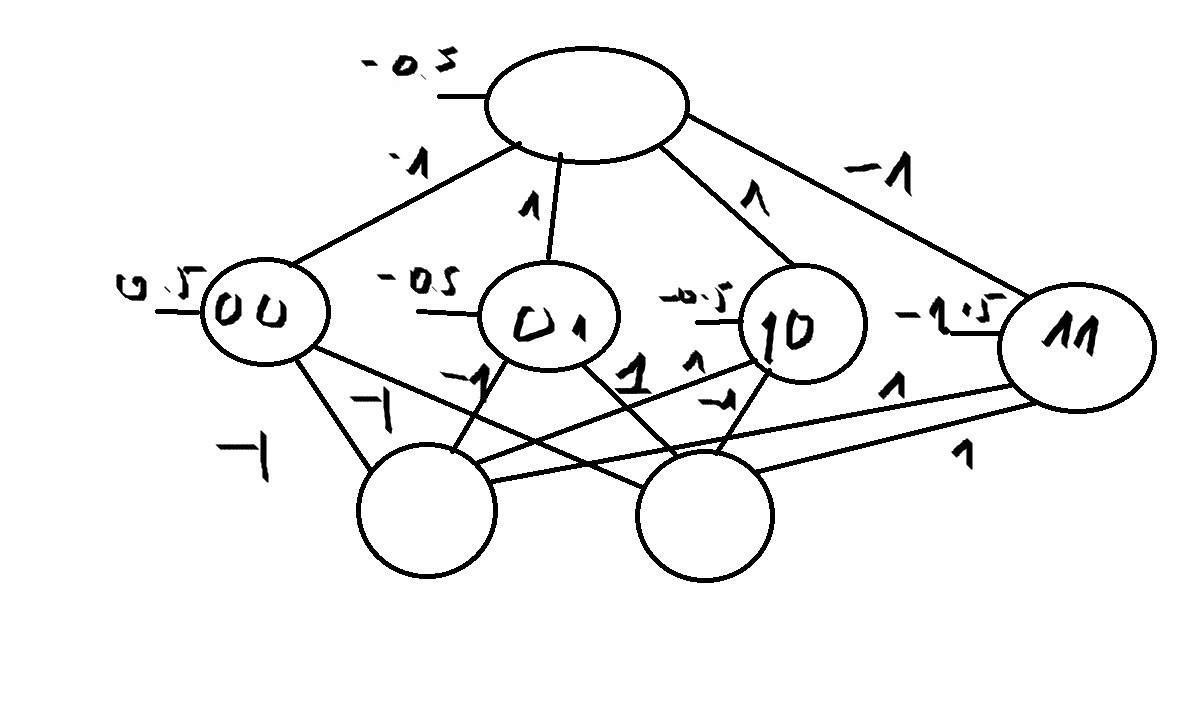

פונקציה שבודקת את היעילות של הרשת הזו

In [ ]:
def Loss(out, t_train):
  return -torch.sum(t_train * torch.log(out) + (1.0 - t_train) * torch.log(1.0 - out))  # Cross Entropy loss function

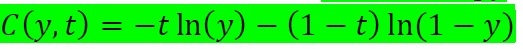

פונקציה שמבצעת למידה ומעדנת משקולות

In [ ]:
def train(network, x_train, t_train, optimizer):
  y_pred = network.forward(x_train) #returns the prediction
  loss = Loss(y_pred, t_train) #calcs CE error

  #GD METHOD
  # zero gradients berfore running the backward pass --> gradient = zero
  optimizer.zero_grad()

  # backward pass to compute the gradient of loss
  # backprop + accumulate 
  loss.backward()

  # update params
  optimizer.step() # weights = weights + delta
  return loss

הקבועים עבור כל הניסויים

In [ ]:
#ALL CONSTS
max_epochs = 40000
good_validation_loss = 0.2

#train
train_set = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)
train_target = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32)

#validation
validation_set = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1] , [1,0.1], [1,0.9], [0.9,0.9], [0.1,0.9]], dtype=torch.float32)
validation_target = torch.tensor([[0], [1], [1], [0],[1],[0],[0],[1]], dtype=torch.float32)

#input
input_nums = 2


ניצור פונקציה שתהיה הלולאה הנידרשת ללמידה עם 2 תנאי העצירה

In [ ]:
#THE LOOP
def expiriment(k , Learning_rate, Bypass):
  model = Network(k, input_nums, bypass= Bypass)
  optimizer = torch.optim.SGD(model.parameters(), lr=Learning_rate)

  old_validation_loss = 0
  counter_loops = 0

  #create the loop
  for i in range(max_epochs):
    train_loss= train(model, train_set, train_target, optimizer) #training
    validation_loss = Loss(model.forward(validation_set), validation_target) #validating

    #check counter
    if validation_loss - old_validation_loss < 0.0001:
      counter_loops += 1
    else:
      counter_loops = 0
    # success
    if validation_loss < good_validation_loss and counter_loops >= 10:
      return (1, i, validation_loss, train_loss)
    
    old_validation_loss = validation_loss
  
  return (0, 0, 0, 0)
    


ניסוי 1 

Learning rate = 0.1 , k = 4 , Bypass=True

In [ ]:
k1 = 4
Learning_rate1 = 0.1
bypass1 = True

counter = 0
fail_counter = 0
data = {}
list_epochs = []
list_train_loss = []
list_validation_loss = []

while counter < 10:
    (succes, num_epochs, validation_loss, train_loss) = expiriment(k1, Learning_rate1, bypass1)
    if succes == 1:
      data[counter] =  (num_epochs, validation_loss, train_loss)
      list_epochs.append(num_epochs)
      list_train_loss.append(train_loss.detach().numpy())
      list_validation_loss.append(validation_loss.detach().numpy())
      counter +=1
    else:
      fail_counter +=1

#AVG
avg_epochs1 = np.average(list_epochs)
avg_train_loss = np.average(list_train_loss)
avg_validation_loss = np.average(list_validation_loss)

#STD
std_epochs1 = np.std(list_epochs)
std_train_loss = np.std(list_train_loss)
std_validation_loss = np.std(list_validation_loss)

#PRINT
for i in range (10):
  print(data[i])

print()
print("AVG:")
print("epochs = ", avg_epochs1, "train loss = ", avg_train_loss, "validation loss= ", avg_validation_loss)

print()
print("STD:")
print("epochs = ", std_epochs1, "train loss = ", std_train_loss, "validation loss= ", std_validation_loss)

print()
print("failed tries = ", fail_counter)

(771, tensor(0.1997, grad_fn=<NegBackward>), tensor(0.0525, grad_fn=<NegBackward>))
(562, tensor(0.1998, grad_fn=<NegBackward>), tensor(0.0666, grad_fn=<NegBackward>))
(636, tensor(0.1999, grad_fn=<NegBackward>), tensor(0.0539, grad_fn=<NegBackward>))
(658, tensor(0.1999, grad_fn=<NegBackward>), tensor(0.0547, grad_fn=<NegBackward>))
(710, tensor(0.1998, grad_fn=<NegBackward>), tensor(0.0542, grad_fn=<NegBackward>))
(836, tensor(0.1999, grad_fn=<NegBackward>), tensor(0.0497, grad_fn=<NegBackward>))
(662, tensor(0.1998, grad_fn=<NegBackward>), tensor(0.0601, grad_fn=<NegBackward>))
(1392, tensor(0.1999, grad_fn=<NegBackward>), tensor(0.0467, grad_fn=<NegBackward>))
(765, tensor(0.1999, grad_fn=<NegBackward>), tensor(0.0578, grad_fn=<NegBackward>))
(749, tensor(0.2000, grad_fn=<NegBackward>), tensor(0.0511, grad_fn=<NegBackward>))

AVG:
epochs =  774.1 train loss =  0.054728247 validation loss=  0.19986364

STD:
epochs =  219.21836145724654 train loss =  0.005373509 validation loss=  6.8

ניסוי 2

Learning rate = 0.1 , k = 4 , Bypass= False

In [ ]:
k2 = 4
Learning_rate2 = 0.1
bypass2 = False

counter = 0
fail_counter = 0
data = {}
list_epochs = []
list_train_loss = []
list_validation_loss = []

while counter < 10:
    (succes, num_epochs, validation_loss, train_loss) = expiriment(k2, Learning_rate2, bypass2)
    if succes == 1:
      data[counter] =  (num_epochs, validation_loss, train_loss)
      list_epochs.append(num_epochs)
      list_train_loss.append(train_loss.detach().numpy())
      list_validation_loss.append(validation_loss.detach().numpy())
      counter +=1
    else:
      fail_counter +=1

#AVG
avg_epochs2 = np.average(list_epochs)
avg_train_loss = np.average(list_train_loss)
avg_validation_loss = np.average(list_validation_loss)

#STD
std_epochs2 = np.std(list_epochs)
std_train_loss = np.std(list_train_loss)
std_validation_loss = np.std(list_validation_loss)

#PRINT
for i in range (10):
  print(data[i])

print()
print("AVG:")
print("epochs = ", avg_epochs2, "train loss = ", avg_train_loss, "validation loss= ", avg_validation_loss)

print()
print("STD:")
print("epochs = ", std_epochs2, "train loss = ", std_train_loss, "validation loss= ", std_validation_loss)

print()
print("failed tries = ", fail_counter)


(519, tensor(0.1995, grad_fn=<NegBackward>), tensor(0.0639, grad_fn=<NegBackward>))
(612, tensor(0.1996, grad_fn=<NegBackward>), tensor(0.0623, grad_fn=<NegBackward>))
(617, tensor(0.1997, grad_fn=<NegBackward>), tensor(0.0684, grad_fn=<NegBackward>))
(635, tensor(0.1996, grad_fn=<NegBackward>), tensor(0.0692, grad_fn=<NegBackward>))
(558, tensor(0.1995, grad_fn=<NegBackward>), tensor(0.0670, grad_fn=<NegBackward>))
(539, tensor(0.1996, grad_fn=<NegBackward>), tensor(0.0670, grad_fn=<NegBackward>))
(622, tensor(0.1999, grad_fn=<NegBackward>), tensor(0.0675, grad_fn=<NegBackward>))
(734, tensor(0.1999, grad_fn=<NegBackward>), tensor(0.0695, grad_fn=<NegBackward>))
(605, tensor(0.1997, grad_fn=<NegBackward>), tensor(0.0675, grad_fn=<NegBackward>))
(544, tensor(0.1996, grad_fn=<NegBackward>), tensor(0.0638, grad_fn=<NegBackward>))

AVG:
epochs =  598.5 train loss =  0.066607006 validation loss=  0.19966409

STD:
epochs =  59.3990740668573 train loss =  0.0023136868 validation loss=  0.000

ניסוי 3

Learning rate = 0.1 , k = 2 , Bypass=True

In [ ]:
k3 = 2
Learning_rate3 = 0.1
bypass3 = True

counter = 0
fail_counter = 0
data = {}
list_epochs = []
list_train_loss = []
list_validation_loss = []

while counter < 10:
    (succes, num_epochs, validation_loss, train_loss) = expiriment(k3, Learning_rate3, bypass3)
    if succes == 1:
      data[counter] =  (num_epochs, validation_loss, train_loss)
      list_epochs.append(num_epochs)
      list_train_loss.append(train_loss.detach().numpy())
      list_validation_loss.append(validation_loss.detach().numpy())
      counter +=1
    else:
      fail_counter +=1

#AVG
avg_epochs3 = np.average(list_epochs)
avg_train_loss = np.average(list_train_loss)
avg_validation_loss = np.average(list_validation_loss)

#STD
std_epochs3 = np.std(list_epochs)
std_train_loss = np.std(list_train_loss)
std_validation_loss = np.std(list_validation_loss)

#PRINT
for i in range (10):
  print(data[i])

print()
print("AVG:")
print("epochs = ", avg_epochs3, "train loss = ", avg_train_loss, "validation loss= ", avg_validation_loss)

print()
print("STD:")
print("epochs = ", std_epochs3, "train loss = ", std_train_loss, "validation loss= ", std_validation_loss)

print()
print("failed tries = ", fail_counter)

(982, tensor(0.1999, grad_fn=<NegBackward>), tensor(0.0528, grad_fn=<NegBackward>))
(931, tensor(0.2000, grad_fn=<NegBackward>), tensor(0.0508, grad_fn=<NegBackward>))
(925, tensor(0.1999, grad_fn=<NegBackward>), tensor(0.0522, grad_fn=<NegBackward>))
(1477, tensor(0.1999, grad_fn=<NegBackward>), tensor(0.0451, grad_fn=<NegBackward>))
(1383, tensor(0.1999, grad_fn=<NegBackward>), tensor(0.0439, grad_fn=<NegBackward>))
(1518, tensor(0.1999, grad_fn=<NegBackward>), tensor(0.0456, grad_fn=<NegBackward>))
(724, tensor(0.1998, grad_fn=<NegBackward>), tensor(0.0599, grad_fn=<NegBackward>))
(1467, tensor(0.2000, grad_fn=<NegBackward>), tensor(0.0457, grad_fn=<NegBackward>))
(1175, tensor(0.2000, grad_fn=<NegBackward>), tensor(0.0504, grad_fn=<NegBackward>))
(936, tensor(0.1998, grad_fn=<NegBackward>), tensor(0.0522, grad_fn=<NegBackward>))

AVG:
epochs =  1151.8 train loss =  0.049865913 validation loss=  0.19990867

STD:
epochs =  274.19073653207175 train loss =  0.004652912 validation loss=

ניסוי 4

Learning rate = 0.1 , k = 2 , Bypass= False

In [ ]:
k4 = 2
Learning_rate4 = 0.1
bypass4 = False

counter = 0
fail_counter = 0
data = {}
list_epochs = []
list_train_loss = []
list_validation_loss = []

while counter < 10:
    (succes, num_epochs, validation_loss, train_loss) = expiriment(k4, Learning_rate4, bypass4)
    if succes == 1:
      data[counter] =  (num_epochs, validation_loss, train_loss)
      list_epochs.append(num_epochs)
      list_train_loss.append(train_loss.detach().numpy())
      list_validation_loss.append(validation_loss.detach().numpy())
      counter +=1
    else:
      fail_counter +=1

#AVG
avg_epochs4 = np.average(list_epochs)
avg_train_loss = np.average(list_train_loss)
avg_validation_loss = np.average(list_validation_loss)

#STD
std_epochs4 = np.std(list_epochs)
std_train_loss = np.std(list_train_loss)
std_validation_loss = np.std(list_validation_loss)

#PRINT
for i in range (10):
  print(data[i])

print()
print("AVG:")
print("epochs = ", avg_epochs4, "train loss = ", avg_train_loss, "validation loss= ", avg_validation_loss)

print()
print("STD:")
print("epochs = ", std_epochs4, "train loss = ", std_train_loss, "validation loss= ", std_validation_loss)

print()
print("failed tries = ", fail_counter)

(2206, tensor(0.1994, grad_fn=<NegBackward>), tensor(0.0633, grad_fn=<NegBackward>))
(724, tensor(0.1999, grad_fn=<NegBackward>), tensor(0.0705, grad_fn=<NegBackward>))
(578, tensor(0.2000, grad_fn=<NegBackward>), tensor(0.0702, grad_fn=<NegBackward>))
(644, tensor(0.1996, grad_fn=<NegBackward>), tensor(0.0695, grad_fn=<NegBackward>))
(1800, tensor(0.1997, grad_fn=<NegBackward>), tensor(0.0642, grad_fn=<NegBackward>))
(786, tensor(0.1998, grad_fn=<NegBackward>), tensor(0.0671, grad_fn=<NegBackward>))
(647, tensor(0.1998, grad_fn=<NegBackward>), tensor(0.0705, grad_fn=<NegBackward>))
(717, tensor(0.1998, grad_fn=<NegBackward>), tensor(0.0693, grad_fn=<NegBackward>))
(719, tensor(0.1998, grad_fn=<NegBackward>), tensor(0.0695, grad_fn=<NegBackward>))
(907, tensor(0.1998, grad_fn=<NegBackward>), tensor(0.0745, grad_fn=<NegBackward>))

AVG:
epochs =  972.8 train loss =  0.06886293 validation loss=  0.19976097

STD:
epochs =  529.7298934362682 train loss =  0.0030933411 validation loss=  0.0

ניסוי 5

Learning rate = 0.01 , k = 4 , Bypass= True

In [ ]:
k5 = 4
Learning_rate5 = 0.01
bypass5 = True

counter = 0
fail_counter = 0
data = {}
list_epochs = []
list_train_loss = []
list_validation_loss = []

while counter < 10:
    (succes, num_epochs, validation_loss, train_loss) = expiriment(k5, Learning_rate5, bypass5)
    if succes == 1:
      data[counter] =  (num_epochs, validation_loss, train_loss)
      list_epochs.append(num_epochs)
      list_train_loss.append(train_loss.detach().numpy())
      list_validation_loss.append(validation_loss.detach().numpy())
      counter +=1
    else:
      fail_counter +=1

#AVG
avg_epochs5 = np.average(list_epochs)
avg_train_loss = np.average(list_train_loss)
avg_validation_loss = np.average(list_validation_loss)

#STD
std_epochs5 = np.std(list_epochs)
std_train_loss = np.std(list_train_loss)
std_validation_loss = np.std(list_validation_loss)

#PRINT
for i in range (10):
  print(data[i])

print()
print("AVG:")
print("epochs = ", avg_epochs5, "train loss = ", avg_train_loss, "validation loss= ", avg_validation_loss)

print()
print("STD:")
print("epochs = ", std_epochs5, "train loss = ", std_train_loss, "validation loss= ", std_validation_loss)

print()
print("failed tries = ", fail_counter)

(7840, tensor(0.2000, grad_fn=<NegBackward>), tensor(0.0505, grad_fn=<NegBackward>))
(8899, tensor(0.2000, grad_fn=<NegBackward>), tensor(0.0473, grad_fn=<NegBackward>))
(6530, tensor(0.2000, grad_fn=<NegBackward>), tensor(0.0603, grad_fn=<NegBackward>))
(11599, tensor(0.2000, grad_fn=<NegBackward>), tensor(0.0424, grad_fn=<NegBackward>))
(8606, tensor(0.2000, grad_fn=<NegBackward>), tensor(0.0508, grad_fn=<NegBackward>))
(6348, tensor(0.2000, grad_fn=<NegBackward>), tensor(0.0568, grad_fn=<NegBackward>))
(6426, tensor(0.2000, grad_fn=<NegBackward>), tensor(0.0565, grad_fn=<NegBackward>))
(11451, tensor(0.2000, grad_fn=<NegBackward>), tensor(0.0431, grad_fn=<NegBackward>))
(6738, tensor(0.2000, grad_fn=<NegBackward>), tensor(0.0608, grad_fn=<NegBackward>))
(10661, tensor(0.2000, grad_fn=<NegBackward>), tensor(0.0429, grad_fn=<NegBackward>))

AVG:
epochs =  8509.8 train loss =  0.051139165 validation loss=  0.19998252

STD:
epochs =  1987.5946166157726 train loss =  0.006799445 validati

ניסוי 6

Learning rate = 0.01 , k = 4 , Bypass= False

In [ ]:
k6 = 4
Learning_rate6 = 0.01
bypass6 = False

counter = 0
fail_counter = 0
data = {}
list_epochs = []
list_train_loss = []
list_validation_loss = []

while counter < 10:
    (succes, num_epochs, validation_loss, train_loss) = expiriment(k6, Learning_rate6, bypass6)
    if succes == 1:
      data[counter] =  (num_epochs, validation_loss, train_loss)
      list_epochs.append(num_epochs)
      list_train_loss.append(train_loss.detach().numpy())
      list_validation_loss.append(validation_loss.detach().numpy())
      counter +=1
    else:
      fail_counter +=1

#AVG
avg_epochs6 = np.average(list_epochs)
avg_train_loss = np.average(list_train_loss)
avg_validation_loss = np.average(list_validation_loss)

#STD
std_epochs6 = np.std(list_epochs)
std_train_loss = np.std(list_train_loss)
std_validation_loss = np.std(list_validation_loss)

#PRINT
for i in range (10):
  print(data[i])

print()
print("AVG:")
print("epochs = ", avg_epochs6, "train loss = ", avg_train_loss, "validation loss= ", avg_validation_loss)

print()
print("STD:")
print("epochs = ", std_epochs6, "train loss = ", std_train_loss, "validation loss= ", std_validation_loss)

print()
print("failed tries = ", fail_counter)

(5602, tensor(0.2000, grad_fn=<NegBackward>), tensor(0.0663, grad_fn=<NegBackward>))
(5737, tensor(0.1999, grad_fn=<NegBackward>), tensor(0.0660, grad_fn=<NegBackward>))
(6670, tensor(0.2000, grad_fn=<NegBackward>), tensor(0.0686, grad_fn=<NegBackward>))
(6492, tensor(0.2000, grad_fn=<NegBackward>), tensor(0.0696, grad_fn=<NegBackward>))
(8359, tensor(0.2000, grad_fn=<NegBackward>), tensor(0.0677, grad_fn=<NegBackward>))
(6430, tensor(0.2000, grad_fn=<NegBackward>), tensor(0.0694, grad_fn=<NegBackward>))
(6566, tensor(0.2000, grad_fn=<NegBackward>), tensor(0.0687, grad_fn=<NegBackward>))
(7888, tensor(0.2000, grad_fn=<NegBackward>), tensor(0.0720, grad_fn=<NegBackward>))
(6323, tensor(0.2000, grad_fn=<NegBackward>), tensor(0.0694, grad_fn=<NegBackward>))
(6765, tensor(0.2000, grad_fn=<NegBackward>), tensor(0.0697, grad_fn=<NegBackward>))

AVG:
epochs =  6683.2 train loss =  0.068745375 validation loss=  0.19996853

STD:
epochs =  810.8729616900542 train loss =  0.001658752 validation l

ניסוי 7

Learning rate = 0.01 , k = 2 , Bypass=True

In [ ]:
k7 = 2
Learning_rate7 = 0.01
bypass7 = True

counter = 0
fail_counter = 0
data = {}
list_epochs = []
list_train_loss = []
list_validation_loss = []

while counter < 10:
    (succes, num_epochs, validation_loss, train_loss) = expiriment(k7, Learning_rate7, bypass7)
    if succes == 1:
      data[counter] =  (num_epochs, validation_loss, train_loss)
      list_epochs.append(num_epochs)
      list_train_loss.append(train_loss.detach().numpy())
      list_validation_loss.append(validation_loss.detach().numpy())
      counter +=1
    else:
      fail_counter +=1

#AVG
avg_epochs7 = np.average(list_epochs)
avg_train_loss = np.average(list_train_loss)
avg_validation_loss = np.average(list_validation_loss)

#STD
std_epochs7 = np.std(list_epochs)
std_train_loss = np.std(list_train_loss)
std_validation_loss = np.std(list_validation_loss)

#PRINT
for i in range (10):
  print(data[i])

print()
print("AVG:")
print("epochs = ", avg_epochs7, "train loss = ", avg_train_loss, "validation loss= ", avg_validation_loss)

print()
print("STD:")
print("epochs = ", std_epochs7, "train loss = ", std_train_loss, "validation loss= ", std_validation_loss)

print()
print("failed tries = ", fail_counter)

(10397, tensor(0.2000, grad_fn=<NegBackward>), tensor(0.0491, grad_fn=<NegBackward>))
(15145, tensor(0.2000, grad_fn=<NegBackward>), tensor(0.0456, grad_fn=<NegBackward>))
(11029, tensor(0.2000, grad_fn=<NegBackward>), tensor(0.0509, grad_fn=<NegBackward>))
(13987, tensor(0.2000, grad_fn=<NegBackward>), tensor(0.0457, grad_fn=<NegBackward>))
(12167, tensor(0.2000, grad_fn=<NegBackward>), tensor(0.0426, grad_fn=<NegBackward>))
(7627, tensor(0.2000, grad_fn=<NegBackward>), tensor(0.0542, grad_fn=<NegBackward>))
(8018, tensor(0.2000, grad_fn=<NegBackward>), tensor(0.0591, grad_fn=<NegBackward>))
(15657, tensor(0.2000, grad_fn=<NegBackward>), tensor(0.0458, grad_fn=<NegBackward>))
(13923, tensor(0.2000, grad_fn=<NegBackward>), tensor(0.0483, grad_fn=<NegBackward>))
(9393, tensor(0.2000, grad_fn=<NegBackward>), tensor(0.0516, grad_fn=<NegBackward>))

AVG:
epochs =  11734.3 train loss =  0.049287193 validation loss=  0.19998738

STD:
epochs =  2748.1093155113026 train loss =  0.004611089 val

ניסוי 8

Learning rate = 0.01 , k = 2 , Bypass= Flase

In [ ]:
k8 = 2
Learning_rate8 = 0.01
bypass8 = False

counter = 0
fail_counter = 0
data = {}
list_epochs = []
list_train_loss = []
list_validation_loss = []

while counter < 10:
    (succes, num_epochs, validation_loss, train_loss) = expiriment(k8, Learning_rate8, bypass8)
    if succes == 1:
      data[counter] =  (num_epochs, validation_loss, train_loss)
      list_epochs.append(num_epochs)
      list_train_loss.append(train_loss.detach().numpy())
      list_validation_loss.append(validation_loss.detach().numpy())
      counter +=1
    else:
      fail_counter +=1

#AVG
avg_epochs8 = np.average(list_epochs)
avg_train_loss = np.average(list_train_loss)
avg_validation_loss = np.average(list_validation_loss)

#STD
std_epochs8 = np.std(list_epochs)
std_train_loss = np.std(list_train_loss)
std_validation_loss = np.std(list_validation_loss)

#PRINT
for i in range (10):
  print(data[i])

print()
print("AVG:")
print("epochs = ", avg_epochs8, "train loss = ", avg_train_loss, "validation loss= ", avg_validation_loss)

print()
print("STD:")
print("epochs = ", std_epochs8, "train loss = ", std_train_loss, "validation loss= ", std_validation_loss)

print()
print("failed tries = ", fail_counter)

(7807, tensor(0.2000, grad_fn=<NegBackward>), tensor(0.0698, grad_fn=<NegBackward>))
(6944, tensor(0.2000, grad_fn=<NegBackward>), tensor(0.0696, grad_fn=<NegBackward>))
(6184, tensor(0.2000, grad_fn=<NegBackward>), tensor(0.0695, grad_fn=<NegBackward>))
(8177, tensor(0.2000, grad_fn=<NegBackward>), tensor(0.0682, grad_fn=<NegBackward>))
(6748, tensor(0.2000, grad_fn=<NegBackward>), tensor(0.0692, grad_fn=<NegBackward>))
(6044, tensor(0.2000, grad_fn=<NegBackward>), tensor(0.0704, grad_fn=<NegBackward>))
(5713, tensor(0.2000, grad_fn=<NegBackward>), tensor(0.0699, grad_fn=<NegBackward>))
(7989, tensor(0.2000, grad_fn=<NegBackward>), tensor(0.0705, grad_fn=<NegBackward>))
(5461, tensor(0.2000, grad_fn=<NegBackward>), tensor(0.0704, grad_fn=<NegBackward>))
(6089, tensor(0.2000, grad_fn=<NegBackward>), tensor(0.0705, grad_fn=<NegBackward>))

AVG:
epochs =  6715.6 train loss =  0.0697964 validation loss=  0.1999819

STD:
epochs =  933.1188777428094 train loss =  0.00070526765 validation lo

ניסוי 9 

Learning rate = 0.1 , k = 1 , Bypass= True

In [ ]:
k9 = 1
Learning_rate9 = 0.1
bypass9 = True

counter = 0
fail_counter = 0
data = {}
list_epochs = []
list_train_loss = []
list_validation_loss = []

while counter < 10:
    (succes, num_epochs, validation_loss, train_loss) = expiriment(k9, Learning_rate9, bypass9)
    if succes == 1:
      data[counter] =  (num_epochs, validation_loss, train_loss)
      list_epochs.append(num_epochs)
      list_train_loss.append(train_loss.detach().numpy())
      list_validation_loss.append(validation_loss.detach().numpy())
      counter +=1
    else:
      fail_counter +=1

#AVG
avg_epochs9 = np.average(list_epochs)
avg_train_loss = np.average(list_train_loss)
avg_validation_loss = np.average(list_validation_loss)

#STD
std_epochs9 = np.std(list_epochs)
std_train_loss = np.std(list_train_loss)
std_validation_loss = np.std(list_validation_loss)

#PRINT
for i in range (10):
  print(data[i])

print()
print("AVG:")
print("epochs = ", avg_epochs9, "train loss = ", avg_train_loss, "validation loss= ", avg_validation_loss)

print()
print("STD:")
print("epochs = ", std_epochs9, "train loss = ", std_train_loss, "validation loss= ", std_validation_loss)

print()
print("failed tries = ", fail_counter)

Streaming output truncated to the last 5000 lines.
        [1.0000, 0.9000],
        [0.9000, 0.9000],
        [0.1000, 0.9000]])  -->  tensor([[0.0238],
        [0.9923],
        [0.9923],
        [1.0000],
        [0.9967],
        [1.0000],
        [1.0000],
        [0.9923]], grad_fn=<MulBackward0>)
tensor([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]])  -->  tensor([[0.0238],
        [0.9923],
        [0.9923],
        [1.0000]], grad_fn=<MulBackward0>)
tensor([[0.0000, 0.0000],
        [0.0000, 1.0000],
        [1.0000, 0.0000],
        [1.0000, 1.0000],
        [1.0000, 0.1000],
        [1.0000, 0.9000],
        [0.9000, 0.9000],
        [0.1000, 0.9000]])  -->  tensor([[0.0238],
        [0.9923],
        [0.9923],
        [1.0000],
        [0.9967],
        [1.0000],
        [1.0000],
        [0.9923]], grad_fn=<MulBackward0>)
tensor([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]])  -->  tensor([[0.0238],
        [0.9923],
        [0.9923],
  

היות ומדובר ברשת עם מעקף ולפונקציה יש 2 קלטים עבורם מתקבל 1 - תפקידו של הניורון הנסתר הוא לבצע פונקציות לוגיות שהן

OR , AND


סעיף ז - גרפים

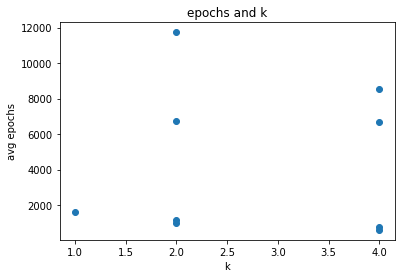

In [ ]:
#GRAPHS
all_epochs_avg = (avg_epochs1,avg_epochs2,avg_epochs3,avg_epochs4,avg_epochs5,avg_epochs6,avg_epochs7,avg_epochs8,avg_epochs9)
all_k = (k1,k2,k3,k4,k5,k6,k7,k8,k9)
all_bypass = (bypass1, bypass2,bypass3,bypass4,bypass5,bypass6,bypass7,bypass8,bypass9)
all_lr = (Learning_rate1, Learning_rate2, Learning_rate3, Learning_rate4, Learning_rate5, Learning_rate6, Learning_rate7, Learning_rate8, Learning_rate9)
all_std = (std_epochs1,std_epochs2,std_epochs3,std_epochs4,std_epochs5,std_epochs6,std_epochs7,std_epochs8,std_epochs9)

# Plot 1
plt.scatter(all_k, all_epochs_avg)
plt.title('epochs and k')
plt.xlabel('k')
plt.ylabel('avg epochs')
plt.show()



רואים בגרף מספר האיפוקים כתלות במספר הניורונים משתנה , קשה להסיק מסקנה מיידית מחוסר בשימוש בפיצ'רים נוספים. ניתן להניח שהמסקנה המיידית היא שככל שיש יותר ניורוים ניסתרים מספר האיפוקים קטן

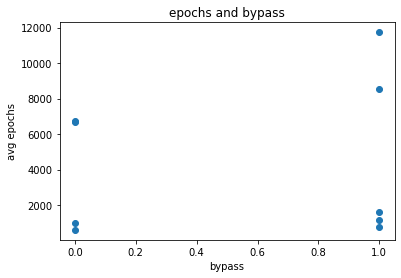

In [ ]:
# Plot 2
plt.scatter(all_bypass, all_epochs_avg)
plt.title('epochs and bypass')
plt.xlabel('bypass')
plt.ylabel('avg epochs')
plt.show()

רואים בגרף מספר האיפוקים כתלות בהאם קיים מעקף או לא , קשה להסיק מסקנה מיידית מחוסר בשימוש בפיצ'רים נוספים . ניתן להניח שהמסקנה המיידית היא שכאשר יש מעקף מספר האיפוקים גדל

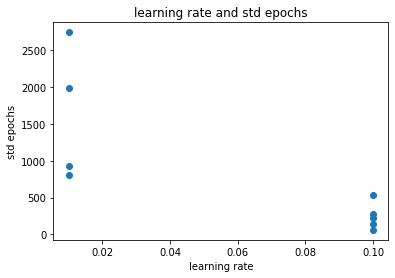

In [ ]:
# Plot 3
plt.scatter(all_lr, all_std)
plt.title('learning rate and std epochs')
plt.xlabel('learning rate')
plt.ylabel('std epochs')
plt.show()

רואים בגרף סטיית תקן של מספר האיפוקים כתלות בקבוע הלמידה ,   המסקנה המיידית היא שכאשר יש קבוע למידה גדול יותר מספר האיפוקים קטן